# Data Analytics Final Project - Speed Dating Predictions

By: Chasen Mauldin, Ian Hoang, Aidan Manning, Son K Do

### The data science problem we are trying to solve:

- What characteristics and interests of an individual influence their match rates while speed dating?

### Why does the problem matter? 

- Many people participate in speed dating and desire a sense of value and urn for a romantic relationship with others. At the end of these said speed dates, a lot of people go unmatched and have a feeling of confusion and of being undesirable. In a world of artificial presentation through social media and online dating, how can we be more genuine while also improving our match rates.

### The results of our predictive model can be used for:

- This provides further insight into current day applications of online dating and could be used to improve match algorithms and methods.

### We are wanting to be able to predict this because:


- By understanding the information and the relationships between these features and match rates, we’ll better understand what generally influences first impressions in speed dating events or online interests.

### Description of the dataset:

 - The dataset we are using was recordings from speed dating results between 2002 and 2004. The main purpose was to see what key contributors were influencing first impressions during speed dating.


### Total number of records of the dataset:

- There were originally 8,379 records in our dataset. After cleaning, we narrowed it down to 516 records.

### Dataset total number of  features:

- There were originally 195 features. After data cleaning, we narrowed it down to the relevant 31 features for our study. A few of which include number of matches, careers, age, interests, and more. 

###  What can you try to predict in this dataset? 


- From this dataset, we can try to predict a match rate range based on the characteristics of an individual including age, gender, and career as well as their  interests such as yoga, sports, tv, etc. 

- We could also use the features in this dataset to make other predictions. For example, we could solely focus on a couple specific features, such as preferred race and religion, and discover how those two features contribute to an individual’s match rate.

### Is this a labeled dataset, appropriate for a supervised learning classification problem? 

- Yes, the data is labeled; the labels are the `match` field. In the uncleaned data set, this was a boolean value for whether or not someone got a match. In our cleaned version, it gives the percentage of matches dependent on how many people they speed dated.

### Link to the dataset:

 Link: https://data.world/annavmontoya/speed-dating-experiment/workspace/file?filename=Speed+Dating+Data.csv

# 0. Data Cleaning

- Originally, the dataset contains records for each interaction between two participants. Since the project only focuses on the percentage of how many matches a person will get, we counted up the number of matches each unique person got based on whether the “match” label was 0 or 1. This reduced the records from more than 8000 to 515 unique people who participated in the speed-dating event. 
- Records from events with confined requirements such as “only undergraduate students” in wave 5 are not included in the final dataset as we want the data to be more random. 
- Using Google Sheet Conditional Formatting, we were able to identify empty cells in the original data. Records with more than 5 missing cells/columns are deleted. For missing data in the “Age” column, the cell is replaced with the average of the age of people who attend the same event (wave). For missing data in the “career” column, the cell is replaced with the mode of people who attend the same event (wave). 
- Columns with significant number of missing data, such as “match_es” which indicate the person’s prediction of how many matches he/she gets, are deleted from the dataset


# 1. Featured Engineering

- To accurately predict the percentage of matches, we transform the continuous attribute “match” into several bins of categorical/nominal attribute (Bin 1 is 0 < match <0.1, etc…). The process of binning is done in Part 2.
- In part 5, before doing KNN classifier, the whole dataset is scaled to [0,1]. In order to improve the accuracy of the model, several other feature engineering techniques were used. Sampling was done by reducing the dataset records number to 475 in part 6b. We also tried wrapper method in part 6a by running the model with a subset of attributes. Unfortunately, neither method provides significant improvement on the accuracy or the recall of the model.


# 2. Import data and prepare bin range for match

In [4]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time

#read the CSV
data = pd.read_csv("speed_dating_data.csv")
missing_values = ['', ' ']

cnt=0
for row in data:      
    try:
        int(row) #try converting to an int
        data.loc[cnt]=np.nan #it worked, make it nan
    except ValueError:
        pass #it did not work, must be a string, leave it be
    cnt+=1

#create new columns
#no matches
data["no_matches"] = data["match"]
#0.01 - 0.25
data["matches1"] = data["match"]
#0.25+ - 0.5
data["matches2"] = data["match"]
#0.50+ - 0.75
data["matches3"] = data["match"]
#0.75+ - 1.0
data["matches4"] = data["match"]



#hot encode based on match rates
for i in range(data.shape[0]):
    #bin them into three separate columns
    #no match bin
    if (data.loc[i, "match"]) == 0:
        data.loc[i,"no_matches"] = 1
    else:
        data.loc[i,"no_matches"] = 0

for i in range(data.shape[0]):
    #bin 0.01=0.25
    if (data.loc[i, "match"]) > 0 and (data.loc[i, "match"]) < 0.25:
        data.loc[i,"matches1"] = 1
    else:
        data.loc[i,"matches1"] = 0


for i in range(data.shape[0]):
    if (data.loc[i, "match"]) >= 0.25 and (data.loc[i, "match"]) < 0.50:
        data.loc[i,"matches2"] = 1
    else:
        data.loc[i,"matches2"] = 0

for i in range(data.shape[0]):
    if (data.loc[i, "match"]) >= 0.50 and (data.loc[i, "match"]) < 0.75:
        data.loc[i,"matches3"] = 1
    else:
        data.loc[i,"matches3"] = 0

for i in range(data.shape[0]):
    if (data.loc[i, "match"]) >= 0.75 and (data.loc[i, "match"]) <= 1.0:
        data.loc[i,"matches4"] = 1
    else:
        data.loc[i,"matches4"] = 0

ori_data = data
# print(data.shape)
data.head(10)

,iid,gender,wave,round,match,age,race,imprace,imprelig,goal,...,concerts,music,shopping,yoga,match_es,no_matches,matches1,matches2,matches3,matches4
0,1,0,1,10,0.4,21,4,2,4,2,...,10,9,8,1,4.0,0.0,0.0,1.0,0.0,0.0
1,2,0,1,10,0.2,24,2,2,5,1,...,7,8,3,1,3.0,0.0,1.0,0.0,0.0,0.0
2,3,0,1,10,0.0,25,2,8,4,6,...,7,5,8,7,NaN,1.0,0.0,0.0,0.0,0.0
3,4,0,1,10,0.2,23,2,1,1,1,...,8,7,1,8,2.0,0.0,1.0,0.0,0.0,0.0
4,5,0,1,10,0.2,21,2,8,1,2,...,3,7,8,3,NaN,0.0,1.0,0.0,0.0,0.0
5,6,0,1,10,0.2,23,4,1,1,1,...,6,4,1,1,4.0,0.0,1.0,0.0,0.0,0.0
6,7,0,1,10,0.2,22,4,2,4,1,...,10,10,10,10,2.0,0.0,1.0,0.0,0.0,0.0
7,8,0,1,10,0.8,25,2,1,1,1,...,6,6,8,6,NaN,0.0,0.0,0.0,0.0,1.0
8,9,0,1,10,0.7,26,6,1,1,1,...,9,9,8,3,1.0,0.0,0.0,0.0,1.0,0.0
9,10,0,1,10,0.2,26,2,4,4,2,...,7,8,7,7,NaN,0.0,1.0,0.0,0.0,0.0


In [5]:
# Drop unnecessary column
data = data.drop(['iid', 'round', 'wave', 'match', 'match_es',],  axis=1)

data.head()

,gender,age,race,imprace,imprelig,goal,date,go_out,career_c,sports,...,movies,concerts,music,shopping,yoga,no_matches,matches1,matches2,matches3,matches4
0,0,21,4,2,4,2,7,1,1,9,...,10,10,9,8,1,0.0,0.0,1.0,0.0,0.0
1,0,24,2,2,5,1,5,1,1,3,...,8,7,8,3,1,0.0,1.0,0.0,0.0,0.0
2,0,25,2,8,4,6,3,1,7,3,...,7,7,5,8,7,1.0,0.0,0.0,0.0,0.0
3,0,23,2,1,1,1,5,1,1,1,...,7,8,7,1,8,0.0,1.0,0.0,0.0,0.0
4,0,21,2,8,1,2,4,1,1,7,...,6,3,7,8,3,0.0,1.0,0.0,0.0,0.0


 # 3. Data Exploration

## a. Bivariate Analysis on match percentage and preference on having the same religion:

#### imprelig- How important is it to you (on a scale of 1-10) that a person you date be of the same religious background?

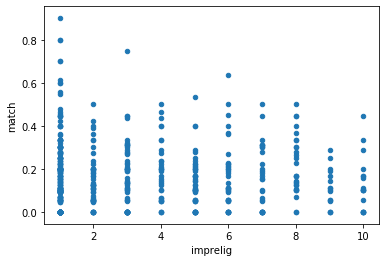

In [6]:
ori_data.plot.scatter(y='match', x='imprelig')


### Using this Bivariate Analysis. You can tell that people who care less about their partner being the same religion as them, would in turn get a higher percentange of matches.

## b. Bivariate Analysis on match percentage and preference on being the same race:

#### imprace - How important is it to you (on a scale of 1-10) that a person you date be of the same racial/ethnic background?

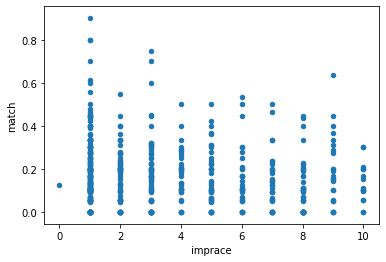

In [7]:
ori_data.plot.scatter(y='match', x='imprace')

### Using this Bivariate Analysis. Just like prefered religion, you can tell that people who care less about their partner being the same race or having the same ethnic background as them, would in turn get a higher percentange of matches.

## c. Pie Chart showing total amount of each gender participating in the study

gender
0    254
1    261
dtype: int64


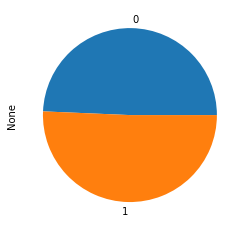

In [8]:
groups = data.groupby('gender')
print(groups.size()) # groups.size() is a Series object
groups.size().plot.pie()

## d. Bivariate Analysis on match percentage and gender:

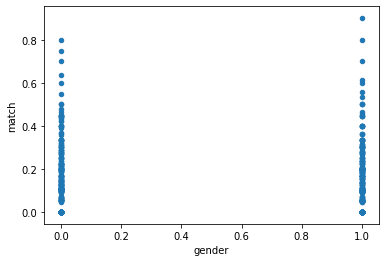

In [9]:
ori_data.plot.scatter(y='match', x='gender')

### Using this Bivariate Analysis. Males (1.0 in the graph above) seemed to be cluster more densely  towards the lower match percentage where as Females (0.0 in the graph above) seemed to be a little higher in match perentange relative to the density of the points.

# 4. Naive Bayes Classifier

In [10]:

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

gnb = GaussianNB()

#split class labels from predictor labels
l = ['no_matches', 'matches1', 'matches2', 'matches3', 'matches4']
res = {}

for d in l:
    data_Y = data[d]
    data_X = data.drop(['no_matches', 'matches1', 'matches2', 'matches3', 'matches4'],  axis=1)

    # data_Y.head(10)
    # data_X.head(10)
    
    cvs = cross_val_score(gnb, data_X, data_Y, cv=10)
    a = cvs.mean()*100
    
    cvp = cross_val_predict(gnb, data_X, data_Y, cv=10)
    print(classification_report(data_Y, cvp))

    res[d] = a

#print accuracy of every bin
for v in res:
    print(v, res[v])





              precision    recall  f1-score   support

         0.0       0.83      0.90      0.87       424
         1.0       0.25      0.15      0.19        91

    accuracy                           0.77       515
   macro avg       0.54      0.53      0.53       515
weighted avg       0.73      0.77      0.75       515

              precision    recall  f1-score   support

         0.0       0.44      0.33      0.38       220
         1.0       0.58      0.68      0.63       295

    accuracy                           0.53       515
   macro avg       0.51      0.51      0.50       515
weighted avg       0.52      0.53      0.52       515

              precision    recall  f1-score   support

         0.0       0.78      0.95      0.86       404
         1.0       0.13      0.03      0.04       111

    accuracy                           0.75       515
   macro avg       0.46      0.49      0.45       515
weighted avg       0.64      0.75      0.68       515

              preci

### Not only do we have to improve accuracy, precision and recall is relatively low and needs to be improved.

# 5. Improving Accuracy with a different classifier (KNN)

In [11]:
#Trying to see any improvvement in accuracy with a new classifier KNN
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

#normalize the data's features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# l = ['no_matches', 'matches1', 'matches2', 'matches3', 'matches4']
d = {'no_matches':-5,"matches1":-4,"matches2":-3,"matches3":-2,"matches4":-1}

for k,v in d.items():
    scaled_Y = scaled_data[:,v]
    scaled_X = scaled_data[:, :-5]

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(scaled_X, scaled_Y)

    cvp = cross_val_predict(neigh, scaled_X, scaled_Y, cv=10)
    print(classification_report(scaled_Y, cvp))
    
    #k values 
    param_grid = {'n_neighbors': list(range(1,31))}

    #to obtain the best k value, use accuracy
    clf = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy')
    clf.fit(scaled_X, scaled_Y)

    print(k)
    #best k value
    print("best K value:", clf.best_params_)

    #accuracy test
    print("Accuracy:", clf.best_score_*100)
    print(" ")





              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89       424
         1.0       0.00      0.00      0.00        91

    accuracy                           0.80       515
   macro avg       0.41      0.49      0.44       515
weighted avg       0.67      0.80      0.73       515

no_matches
best K value: {'n_neighbors': 12}
Accuracy: 82.52262443438913
 
              precision    recall  f1-score   support

         0.0       0.48      0.35      0.40       220
         1.0       0.60      0.72      0.65       295

    accuracy                           0.56       515
   macro avg       0.54      0.53      0.53       515
weighted avg       0.55      0.56      0.55       515

matches1
best K value: {'n_neighbors': 17}
Accuracy: 57.07390648567119
 
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       404
         1.0       0.19      0.06      0.10       111

    accuracy                      

### KNN gives better accuracy but still has terrible precision and recall

# 6. Manipulating Data set to improve accuracy

## a. Only take in account a subset of columns

In [12]:
# Targeted column
target_data = data.iloc[:, :9]
target_data.head()

,gender,age,race,imprace,imprelig,goal,date,go_out,career_c
0,0,21,4,2,4,2,7,1,1
1,0,24,2,2,5,1,5,1,1
2,0,25,2,8,4,6,3,1,7
3,0,23,2,1,1,1,5,1,1
4,0,21,2,8,1,2,4,1,1


In [13]:
#focus on initial characteristics

#normalize the data's features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

new_data = scaled_data[:, :9]

d = {'no_matches':-5,"matches1":-4,"matches2":-3,"matches3":-2,"matches4":-1}

for k,v in d.items():
    scaled_Y = scaled_data[:,v]

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(new_data, scaled_Y)

    cvp = cross_val_predict(neigh, new_data, scaled_Y, cv=10)
    print(classification_report(scaled_Y, cvp))
    
    #k values 
    param_grid = {'n_neighbors': list(range(1,31))}

    #to obtain the best k value, use accuracy
    clf = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy')
    clf.fit(new_data, scaled_Y)

    print(k)
    #best k value
    print("best K value:", clf.best_params_)

    #accuracy test
    print("Accuracy:", clf.best_score_*100)
    print(" ")
    
    

              precision    recall  f1-score   support

         0.0       0.83      0.98      0.90       424
         1.0       0.41      0.08      0.13        91

    accuracy                           0.82       515
   macro avg       0.62      0.53      0.51       515
weighted avg       0.76      0.82      0.76       515

no_matches
best K value: {'n_neighbors': 4}
Accuracy: 82.33031674208145
 
              precision    recall  f1-score   support

         0.0       0.48      0.44      0.46       220
         1.0       0.61      0.64      0.62       295

    accuracy                           0.56       515
   macro avg       0.54      0.54      0.54       515
weighted avg       0.55      0.56      0.55       515

matches1
best K value: {'n_neighbors': 29}
Accuracy: 58.24283559577677
 
              precision    recall  f1-score   support

         0.0       0.78      0.90      0.84       404
         1.0       0.18      0.08      0.11       111

    accuracy                       

## b. Remove last 40 records since the last two waves of the speed dating event have targeted audience instead of random like other waves

In [14]:
#remove certain rows
new_data = data.iloc[0:475,:]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(new_data)

d = {'no_matches':-5,"matches1":-4,"matches2":-3,"matches3":-2,"matches4":-1}

for k,v in d.items():
    scaled_Y = scaled_data[:,v]
    scaled_X = scaled_data[:, :-5]

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(scaled_X, scaled_Y)

    cvp = cross_val_predict(neigh, scaled_X, scaled_Y, cv=10)
    print(classification_report(scaled_Y, cvp))
    
    #k values 
    param_grid = {'n_neighbors': list(range(1,31))}

    #to obtain the best k value, use accuracy
    clf = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy')
    clf.fit(new_data, scaled_Y)

    print(k)
    #best k value
    print("best K value:", clf.best_params_)

    #accuracy test
    print("Accuracy:", clf.best_score_*100)
    print(" ")


              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89       392
         1.0       0.00      0.00      0.00        83

    accuracy                           0.80       475
   macro avg       0.41      0.49      0.45       475
weighted avg       0.68      0.80      0.73       475

no_matches
best K value: {'n_neighbors': 14}
Accuracy: 82.53102836879434
 
              precision    recall  f1-score   support

         0.0       0.46      0.33      0.39       204
         1.0       0.58      0.70      0.64       271

    accuracy                           0.55       475
   macro avg       0.52      0.52      0.51       475
weighted avg       0.53      0.55      0.53       475

matches1
best K value: {'n_neighbors': 22}
Accuracy: 64.20656028368793
 
              precision    recall  f1-score   support

         0.0       0.77      0.91      0.84       371
         1.0       0.13      0.05      0.07       104

    accuracy                      

#### No significant changes

## c. Check for outliers

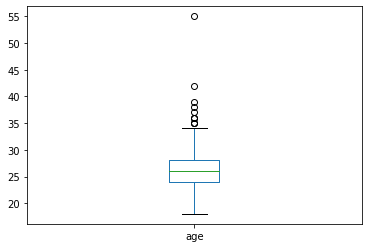

In [15]:
# Two columns with outliers are age and goal
# Check "Age"
data['age'].plot(kind='box')

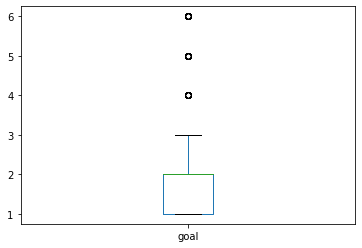

In [16]:
# Check goal
data['goal'].plot(kind='box')

Outliers index
[130, 136, 396, 272, 403, 278, 406, 419, 420, 38, 424, 42, 301, 49, 323, 332, 341, 86, 471, 477, 94, 223, 233, 490, 239, 240, 496, 506, 246, 376, 122, 125]


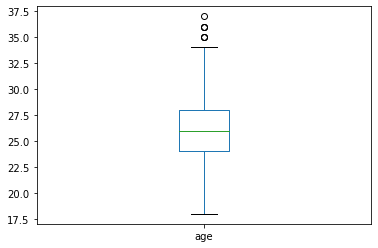

In [17]:
# remove outliers
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(data.iloc[:, :-5]))

out = list(set(np.where(z > 3)[0]))
print("Outliers index")
print(out)

no_outlier_data = data.drop(out, axis = 0)
no_outlier_data['age'].plot(kind='box')

In [18]:
# Test with KNN
#normalize the data's features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(no_outlier_data)

# l = ['no_matches', 'matches1', 'matches2', 'matches3', 'matches4']
d = {'no_matches':-5,"matches1":-4,"matches2":-3,"matches3":-2,"matches4":-1}

for k,v in d.items():
    scaled_Y = scaled_data[:,v]
    scaled_X = scaled_data[:, :-5]

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(scaled_X, scaled_Y)

    cvp = cross_val_predict(neigh, scaled_X, scaled_Y, cv=10)
    print(classification_report(scaled_Y, cvp))
    
    #k values 
    param_grid = {'n_neighbors': list(range(1,31))}

    #to obtain the best k value, use accuracy
    clf = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy')
    clf.fit(scaled_X, scaled_Y)

    print(k)
    #best k value
    print("best K value:", clf.best_params_)

    #accuracy test
    print("Accuracy:", clf.best_score_*100)
    print(" ")





              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89       397
         1.0       0.00      0.00      0.00        86

    accuracy                           0.81       483
   macro avg       0.41      0.49      0.45       483
weighted avg       0.67      0.81      0.73       483

no_matches
best K value: {'n_neighbors': 14}
Accuracy: 82.19812925170068
 
              precision    recall  f1-score   support

         0.0       0.45      0.34      0.39       208
         1.0       0.58      0.68      0.63       275

    accuracy                           0.54       483
   macro avg       0.51      0.51      0.51       483
weighted avg       0.52      0.54      0.52       483

matches1
best K value: {'n_neighbors': 13}
Accuracy: 55.654761904761905
 
              precision    recall  f1-score   support

         0.0       0.78      0.94      0.85       379
         1.0       0.20      0.06      0.09       104

    accuracy                     

### No improvement

## d. Change bin range (3 bins instead of 5)

In [19]:
#read the CSV
test_data = pd.read_csv("speed_dating_data.csv")
missing_values = ['', ' ']



#create new columns

test_data["no_matches"] = test_data["match"]

test_data["matches1"] = test_data["match"]

test_data["matches2"] = test_data["match"]




#hot encode based on match rates
for i in range(test_data.shape[0]):
    #bin them into three separate columns
    # bin 0 to .1 match %
    if (test_data.loc[i, "match"]) <= 0.1:
        test_data.loc[i,"no_matches"] = 1
    else:
        test_data.loc[i,"no_matches"] = 0

for i in range(test_data.shape[0]):
    #bin 0.01 to 0.5 match %
    if (test_data.loc[i, "match"]) > 0.1 and (test_data.loc[i, "match"]) < 0.5:
        test_data.loc[i,"matches1"] = 1
    else:
        test_data.loc[i,"matches1"] = 0


for i in range(test_data.shape[0]):
    #bin .5 to 1 match %
    if (test_data.loc[i, "match"]) >= 0.5:
        test_data.loc[i,"matches2"] = 1
    else:
        test_data.loc[i,"matches2"] = 0


test_data = test_data.drop(['iid', 'round', 'wave', 'match', 'match_es',],  axis=1)
test_data.head(10)

,gender,age,race,imprace,imprelig,goal,date,go_out,career_c,sports,...,tv,theater,movies,concerts,music,shopping,yoga,no_matches,matches1,matches2
0,0,21,4,2,4,2,7,1,1,9,...,9,1,10,10,9,8,1,0.0,1.0,0.0
1,0,24,2,2,5,1,5,1,1,3,...,1,9,8,7,8,3,1,0.0,1.0,0.0
2,0,25,2,8,4,6,3,1,7,3,...,8,7,7,7,5,8,7,1.0,0.0,0.0
3,0,23,2,1,1,1,5,1,1,1,...,7,9,7,8,7,1,8,0.0,1.0,0.0
4,0,21,2,8,1,2,4,1,1,7,...,8,6,6,3,7,8,3,0.0,1.0,0.0
5,0,23,4,1,1,1,3,1,1,10,...,2,5,6,6,4,1,1,0.0,1.0,0.0
6,0,22,4,2,4,1,5,1,1,5,...,8,10,10,10,10,10,10,0.0,1.0,0.0
7,0,25,2,1,1,1,5,1,6,2,...,10,9,9,6,6,8,6,0.0,0.0,1.0
8,0,26,6,1,1,1,4,1,9,4,...,8,10,10,9,9,8,3,0.0,0.0,1.0
9,0,26,2,4,4,2,6,1,9,9,...,5,6,7,7,8,7,7,0.0,1.0,0.0


In [20]:
# Gaussian
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

gnb = GaussianNB()

#split class labels from predictor labels
l = ['no_matches', 'matches1', 'matches2']
res = {}

for d in l:
    test_data_Y = test_data[d]
    test_data_X = test_data.drop(['no_matches', 'matches1', 'matches2'],  axis=1)

    # data_Y.head(10)
    # data_X.head(10)
    
    cvs = cross_val_score(gnb, test_data_X, test_data_Y, cv=10)
    a = cvs.mean()*100
    
    cvp = cross_val_predict(gnb, test_data_X, test_data_Y, cv=10)
    print(classification_report(test_data_Y, cvp))

    res[d] = a

#print accuracy of every bin
for v in res:
    print(v, res[v])

              precision    recall  f1-score   support

         0.0       0.63      0.70      0.66       314
         1.0       0.43      0.35      0.38       201

    accuracy                           0.56       515
   macro avg       0.53      0.52      0.52       515
weighted avg       0.55      0.56      0.55       515

              precision    recall  f1-score   support

         0.0       0.43      0.32      0.37       219
         1.0       0.58      0.70      0.63       296

    accuracy                           0.53       515
   macro avg       0.51      0.51      0.50       515
weighted avg       0.52      0.53      0.52       515

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       497
         1.0       0.12      0.17      0.14        18

    accuracy                           0.93       515
   macro avg       0.54      0.56      0.55       515
weighted avg       0.94      0.93      0.93       515

no_matches 56.30467

In [21]:
# KNN
#normalize the data's features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(test_data)


d = {'no_matches':-3,"matches1":-2,"matches2":-1,}

for k,v in d.items():
    scaled_Y = scaled_data[:,v]
    scaled_X = scaled_data[:, :-3]

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(scaled_X, scaled_Y)

    cvp = cross_val_predict(neigh, scaled_X, scaled_Y, cv=10)
    print(classification_report(scaled_Y, cvp))
    
    #k values 
    param_grid = {'n_neighbors': list(range(1,31))}

    #to obtain the best k value, use accuracy
    clf = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy')
    clf.fit(scaled_X, scaled_Y)

    print(k)
    #best k value
    print("best K value:", clf.best_params_)

    #accuracy test
    print("Accuracy:", clf.best_score_*100)
    print(" ")

              precision    recall  f1-score   support

         0.0       0.61      0.73      0.67       314
         1.0       0.40      0.29      0.34       201

    accuracy                           0.56       515
   macro avg       0.51      0.51      0.50       515
weighted avg       0.53      0.56      0.54       515

no_matches
best K value: {'n_neighbors': 10}
Accuracy: 61.16892911010557
 
              precision    recall  f1-score   support

         0.0       0.44      0.33      0.38       219
         1.0       0.58      0.69      0.63       296

    accuracy                           0.54       515
   macro avg       0.51      0.51      0.50       515
weighted avg       0.52      0.54      0.52       515

matches1
best K value: {'n_neighbors': 29}
Accuracy: 56.104826546003004
 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       497
         1.0       0.00      0.00      0.00        18

    accuracy                     

### Improvement on precision and recall but last bin still suffer. Therefore, we need to add more data for last bin by duplicating records with result in last bin. Overally, the precision and recall of the classifiers would heavily benefit if we have more data in general.

# 7. Voting


### Choose KNN method for the whole dataset, save prediction in an array, use k value from best k value above

In [22]:
from sklearn.metrics import accuracy_score

prediction = []

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(test_data)


d = {'no_matches':-3,"matches1":-2,"matches2":-1,}
k_val = {'no_matches':10,"matches1":29,"matches2":2,} # Obtained from the run aboved

# KNN with the whole dataset
for k,v in d.items():
    scaled_Y = scaled_data[:,v]
    scaled_X = scaled_data[:, :-3]

    neigh = KNeighborsClassifier(n_neighbors=k_val[k])
    neigh.fit(scaled_X, scaled_Y)

    cvp = cross_val_predict(neigh, scaled_X, scaled_Y)
    print(classification_report(scaled_Y, cvp))
    prediction.append(cvp)

print(len(prediction))
print(len(prediction[0]))

              precision    recall  f1-score   support

         0.0       0.62      0.89      0.73       314
         1.0       0.46      0.15      0.23       201

    accuracy                           0.60       515
   macro avg       0.54      0.52      0.48       515
weighted avg       0.56      0.60      0.53       515

              precision    recall  f1-score   support

         0.0       0.46      0.16      0.24       219
         1.0       0.58      0.86      0.69       296

    accuracy                           0.56       515
   macro avg       0.52      0.51      0.47       515
weighted avg       0.53      0.56      0.50       515

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       497
         1.0       0.00      0.00      0.00        18

    accuracy                           0.97       515
   macro avg       0.48      0.50      0.49       515
weighted avg       0.93      0.97      0.95       515

3
515


### Begin voting based on the result of each bin. For example, for bin "no_match", if "no_match" predicts Yes or other bin predicts No, bin "no_match" gets one vote. If "no_match" predicts No or other bin predicts Yes, bin "no_match" doesn't get a vote.  

In [15]:
voting_result = []

# no_match voting
for i in range(len(prediction[0])):
    vote = 0
    for j in range(len(prediction)):
        if j == 0:
            if prediction[j][i] == 1:
                vote += 1
        else:
            if prediction[j][i] == 0:
                vote += 1
    voting_result.append([vote])

# matches1 voting
for i in range(len(prediction[0])):
    vote = 0
    for j in range(len(prediction)):
        if j == 1:
            if prediction[j][i] == 1:
                vote += 1
        else:
            if prediction[j][i] == 0:
                vote += 1
    voting_result[i].append(vote)

    
# matches2 voting
for i in range(len(prediction[0])):
    vote = 0
    for j in range(len(prediction)):
        if j == 2:
            if prediction[j][i] == 1:
                vote += 1
        else:
            if prediction[j][i] == 0:
                vote += 1
    voting_result[i].append(vote)
print("Voting Results of first 10:")
print(voting_result[0:10])


NameError: name 'prediction' is not defined

In [24]:
# Compile y_true
y_true = []

for i in range(ori_data.shape[0]):
    if (ori_data.loc[i, "match"]) <= 0.1:
        y_true.append(0)
    elif (ori_data.loc[i, "match"]) > 0.1 and (ori_data.loc[i, "match"]) < 0.5:
        y_true.append(1)
    else:
        y_true.append(2)
        
# Compile y_predict
from sklearn.metrics import accuracy_score
y_predict = []
for i in range(len(voting_result)):
    if voting_result[i].count(max(voting_result[i])) == 1:
        y_predict.append(voting_result[i].index(max(voting_result[i])))
    else:
        y_predict.append("N/A")

count = 0
for i in range(len(y_true)):
    if y_true[i] == y_predict[i]:
        count += 1

print("Final accuracy of binning:")
print(count/len(y_true)*100)

Final accuracy of binning:
48.349514563106794


# 8. Duplicate bin 3 records to improve f-score of model

### Create a second csv file with duplicated records called duplicated_vals - Speed Dating Data.csv. Repeat the same steps as before

In [42]:
dup_data = pd.read_csv("duplicated_vals - Speed Dating Data.csv")
missing_values = ['', ' ']



test_data["no_matches"] = dup_data["match"]

dup_data["matches1"] = dup_data["match"]

dup_data["matches2"] = dup_data["match"]




#hot encode based on match rates
for i in range(dup_data.shape[0]):
    #bin them into three separate columns
    #no match bin
    if (dup_data.loc[i, "match"]) <= 0.1:
        dup_data.loc[i,"no_matches"] = 1
    else:
        dup_data.loc[i,"no_matches"] = 0

for i in range(dup_data.shape[0]):
    #bin 0.01=0.25
    if (dup_data.loc[i, "match"]) > 0.1 and (dup_data.loc[i, "match"]) < 0.5:
        dup_data.loc[i,"matches1"] = 1
    else:
        dup_data.loc[i,"matches1"] = 0


for i in range(dup_data.shape[0]):
    if (dup_data.loc[i, "match"]) >= 0.5:
        dup_data.loc[i,"matches2"] = 1
    else:
        dup_data.loc[i,"matches2"] = 0

ori_dup_data = dup_data
dup_data = dup_data.drop(['iid', 'round', 'wave', 'match', 'match_es',],  axis=1)
dup_data.head(10)


,gender,age,race,imprace,imprelig,goal,date,go_out,career_c,sports,...,tv,theater,movies,concerts,music,shopping,yoga,matches1,matches2,no_matches
0,0,21,4,2,4,2,7,1,1,9,...,9,1,10,10,9,8,1,1.0,0.0,0.0
1,0,24,2,2,5,1,5,1,1,3,...,1,9,8,7,8,3,1,1.0,0.0,0.0
2,0,25,2,8,4,6,3,1,7,3,...,8,7,7,7,5,8,7,0.0,0.0,1.0
3,0,23,2,1,1,1,5,1,1,1,...,7,9,7,8,7,1,8,1.0,0.0,0.0
4,0,21,2,8,1,2,4,1,1,7,...,8,6,6,3,7,8,3,1.0,0.0,0.0
5,0,23,4,1,1,1,3,1,1,10,...,2,5,6,6,4,1,1,1.0,0.0,0.0
6,0,22,4,2,4,1,5,1,1,5,...,8,10,10,10,10,10,10,1.0,0.0,0.0
7,0,25,2,1,1,1,5,1,6,2,...,10,9,9,6,6,8,6,0.0,1.0,0.0
8,0,26,6,1,1,1,4,1,9,4,...,8,10,10,9,9,8,3,0.0,1.0,0.0
9,0,26,2,4,4,2,6,1,9,9,...,5,6,7,7,8,7,7,1.0,0.0,0.0


## a. KNN with duplicated dataset

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

gnb = GaussianNB()

#split class labels from predictor labels
l = ['no_matches', 'matches1', 'matches2']
res = {}

for d in l:
    dup_data_Y = dup_data[d]
    dup_data_X = dup_data.drop(['no_matches', 'matches1', 'matches2'],  axis=1)

    # data_Y.head(10)
    # data_X.head(10)
    
    cvs = cross_val_score(gnb, dup_data_X, dup_data_Y, cv=10)
    a = cvs.mean()*100
    
    cvp = cross_val_predict(gnb, dup_data_X, dup_data_Y, cv=10)
    print(classification_report(dup_data_Y, cvp))

    res[d] = a

#print accuracy of every bin
for v in res:
    print(v, res[v])

              precision    recall  f1-score   support

         0.0       0.69      0.73      0.71       362
         1.0       0.46      0.41      0.43       201

    accuracy                           0.62       563
   macro avg       0.57      0.57      0.57       563
weighted avg       0.61      0.62      0.61       563

              precision    recall  f1-score   support

         0.0       0.48      0.35      0.41       267
         1.0       0.53      0.66      0.59       296

    accuracy                           0.51       563
   macro avg       0.50      0.50      0.50       563
weighted avg       0.51      0.51      0.50       563

              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92       497
         1.0       0.45      0.62      0.52        66

    accuracy                           0.87       563
   macro avg       0.70      0.76      0.72       563
weighted avg       0.89      0.87      0.88       563

no_matches 61.62593

In [37]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dup_data)


d = {'no_matches':-3,"matches1":-2,"matches2":-1,}

for k,v in d.items():
    scaled_Y = scaled_data[:,v]
    scaled_X = scaled_data[:, :-3]

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(scaled_X, scaled_Y)

    cvp = cross_val_predict(neigh, scaled_X, scaled_Y, cv=10)
    print(classification_report(scaled_Y, cvp))
    
    #k values 
    param_grid = {'n_neighbors': list(range(1,31))}

    #to obtain the best k value, use accuracy
    clf = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy')
    clf.fit(scaled_X, scaled_Y)

    print(k)
    #best k value
    print("best K value:", clf.best_params_)

    #accuracy test
    print("Accuracy:", clf.best_score_*100)
    print(" ")

              precision    recall  f1-score   support

         0.0       0.55      0.49      0.52       267
         1.0       0.58      0.64      0.61       296

    accuracy                           0.57       563
   macro avg       0.56      0.56      0.56       563
weighted avg       0.56      0.57      0.56       563

no_matches
best K value: {'n_neighbors': 1}
Accuracy: 59.69298245614034
 
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96       497
         1.0       0.66      0.97      0.79        66

    accuracy                           0.94       563
   macro avg       0.83      0.95      0.87       563
weighted avg       0.96      0.94      0.94       563

matches1
best K value: {'n_neighbors': 2}
Accuracy: 97.86654135338345
 
              precision    recall  f1-score   support

         0.0       0.67      0.78      0.72       362
         1.0       0.43      0.29      0.34       201

    accuracy                        

In [38]:
from sklearn.metrics import accuracy_score

prediction = []

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dup_data)


d = {'no_matches':-3,"matches1":-2,"matches2":-1,}
k_val = {'no_matches':10,"matches1":29,"matches2":2,} # Obtained from the run aboved

# KNN with the whole dataset
for k,v in d.items():
    scaled_Y = scaled_data[:,v]
    scaled_X = scaled_data[:, :-3]

    neigh = KNeighborsClassifier(n_neighbors=k_val[k])
    neigh.fit(scaled_X, scaled_Y)

    cvp = cross_val_predict(neigh, scaled_X, scaled_Y)
    print(classification_report(scaled_Y, cvp))
    prediction.append(cvp)

print(len(prediction))
print(len(prediction[0]))

              precision    recall  f1-score   support

         0.0       0.50      0.52      0.51       267
         1.0       0.55      0.52      0.54       296

    accuracy                           0.52       563
   macro avg       0.52      0.52      0.52       563
weighted avg       0.52      0.52      0.52       563

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       497
         1.0       0.00      0.00      0.00        66

    accuracy                           0.88       563
   macro avg       0.44      0.50      0.47       563
weighted avg       0.78      0.88      0.83       563

              precision    recall  f1-score   support

         0.0       0.65      0.86      0.74       362
         1.0       0.37      0.14      0.21       201

    accuracy                           0.61       563
   macro avg       0.51      0.50      0.47       563
weighted avg       0.55      0.61      0.55       563

3
563


In [39]:
voting_result = []

# no_match voting
for i in range(len(prediction[0])):
    vote = 0
    for j in range(len(prediction)):
        if j == 0:
            if prediction[j][i] == 1:
                vote += 1
        else:
            if prediction[j][i] == 0:
                vote += 1
    voting_result.append([vote])

# matches1 voting
for i in range(len(prediction[0])):
    vote = 0
    for j in range(len(prediction)):
        if j == 1:
            if prediction[j][i] == 1:
                vote += 1
        else:
            if prediction[j][i] == 0:
                vote += 1
    voting_result[i].append(vote)

    
# matches2 voting
for i in range(len(prediction[0])):
    vote = 0
    for j in range(len(prediction)):
        if j == 2:
            if prediction[j][i] == 1:
                vote += 1
        else:
            if prediction[j][i] == 0:
                vote += 1
    voting_result[i].append(vote)
print("Voting Results of first 10:")
print(voting_result[0:10])

[[3, 1, 1], [3, 1, 1], [3, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [1, 1, 3], [2, 2, 2], [2, 2, 2], [1, 1, 3]]


In [44]:
# Compile y_true
y_true = []

for i in range(ori_dup_data.shape[0]):
    if (ori_dup_data.loc[i, "match"]) <= 0.1:
        y_true.append(0)
    elif (ori_dup_data.loc[i, "match"]) > 0.1 and (ori_dup_data.loc[i, "match"]) < 0.5:
        y_true.append(1)
    else:
        y_true.append(2)
        
# Compile y_predict
from sklearn.metrics import accuracy_score
y_predict = []
for i in range(len(voting_result)):
    if voting_result[i].count(max(voting_result[i])) == 1:
        y_predict.append(voting_result[i].index(max(voting_result[i])))
    else:
        y_predict.append("N/A")

count = 0
for i in range(len(y_true)):
    if y_true[i] == y_predict[i]:
        count += 1
print(len(y_predict))
print(len(y_true))
print("Final accuracy of binning:")
print(count/len(y_true)*100)

563
563
Final accuracy of binning:
17.761989342806395


### Even though duplicating records in bin 3 significantly improves f-score for bins and individual prediction, the final accuracy of prediction percentage of match decreases heavily.

## b. Gaussian

In [45]:
gnb = GaussianNB()

#split class labels from predictor labels
l = ['no_matches', 'matches1', 'matches2']

prediction = []
for d in l:
    dup_data_Y = dup_data[d]
    dup_data_X = dup_data.drop(['no_matches', 'matches1', 'matches2'],  axis=1)
    
    cvp = cross_val_predict(gnb, dup_data_X, dup_data_Y)
    a = cvs.mean()*100
    
    prediction.append(cvp)

In [46]:
voting_result = []

# no_match voting
for i in range(len(prediction[0])):
    vote = 0
    for j in range(len(prediction)):
        if j == 0:
            if prediction[j][i] == 1:
                vote += 1
        else:
            if prediction[j][i] == 0:
                vote += 1
    voting_result.append([vote])

# matches1 voting
for i in range(len(prediction[0])):
    vote = 0
    for j in range(len(prediction)):
        if j == 1:
            if prediction[j][i] == 1:
                vote += 1
        else:
            if prediction[j][i] == 0:
                vote += 1
    voting_result[i].append(vote)

    
# matches2 voting
for i in range(len(prediction[0])):
    vote = 0
    for j in range(len(prediction)):
        if j == 2:
            if prediction[j][i] == 1:
                vote += 1
        else:
            if prediction[j][i] == 0:
                vote += 1
    voting_result[i].append(vote)
print("Voting Results of first 10:")
print(voting_result[0:10])

[[3, 1, 1], [2, 2, 2], [1, 3, 1], [2, 2, 2], [2, 2, 2], [1, 3, 1], [1, 1, 3], [1, 1, 3], [1, 1, 3], [1, 3, 1]]


In [47]:
# Compile y_true
y_true = []

for i in range(ori_dup_data.shape[0]):
    if (ori_dup_data.loc[i, "match"]) <= 0.1:
        y_true.append(0)
    elif (ori_dup_data.loc[i, "match"]) > 0.1 and (ori_dup_data.loc[i, "match"]) < 0.5:
        y_true.append(1)
    else:
        y_true.append(2)
        
# Compile y_predict
from sklearn.metrics import accuracy_score
y_predict = []
for i in range(len(voting_result)):
    if voting_result[i].count(max(voting_result[i])) == 1:
        y_predict.append(voting_result[i].index(max(voting_result[i])))
    else:
        y_predict.append("N/A")

count = 0
for i in range(len(y_true)):
    if y_true[i] == y_predict[i]:
        count += 1
print(len(y_predict))
print(len(y_true))
print("Final accuracy of binning:")
print(count/len(y_true)*100)

563
563
Final accuracy of binning:
28.419182948490228


### Same result as KNN. Final and overall accuracy significantly decreased.

# 9. Conclusion

-  Based on the techniques we implemented, we discovered changes that improved our overall results. When running our data through the Naive Bayes classifier, our accuracies were 77.11%, 53.17%, 75.15%, 89.69%, and 98.06% for each of the five bins respectively. When implementing K Nearest Neighbors (KNN), we found that by changing our number of bins from 5 to 3 improved our results, with accuracies of 61.2%, 56.1%, and 96.5% for each bin respectively. When implementing Gaussian, we achieved accuracies of 56.3%, 53.4%, and 92.6% for each respective bin. We also checked for outliers in both columns for age and goal of speed dating columns. After removing 32 outliers, there was no significant improvement or changes in the results. to determine the effects it had on the results. After binning and voting, our final accuracy was 48.35%. Due to the F-score being very bad for bin 3, we decided to duplicate all of the data for values inside that specific bin. Using KNN, this drastically improved our F-score, but also demisoned the accuracy to 17.76% so we do not recommend going this route. After, we tried using Gaussian with the duplicated values, and it only improved the final accuracy to 28.42. 